 # 1. Motivation
### 1.1 Objective
The objective of the project is to identify a location for a new bar in New York. We want to find a **"sweet spot"** where the area is wealthy, well kept and pleasant while party scene is active. 
 
### 1.2 About the Datasets
In this project, we work with a combination of three datasets:
1. **Open Data from New York City, 3-1-1 Complaints** <br />
*source: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9*<br />
    a. Loud Noise from Bars<br />
    b. Rodents Complaints<br />
    c. Graffiti Complaints<br />
    d. Air Quality Complaints<br />
    c. Public Urinating Complaints<br />
    <br />
2. **Open Data from New York City, Street Tree Census**<br />
*source: https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35*<br />
    a. Total number of trees<br />
    b. Condition of trees (share of total trees that are in good condition)<br />
    <br />
3. **Zillow Home Value Index**<br />
*source: http://files.zillowstatic.com/research/public/Zip/Zip_MedianSoldPricePerSqft_AllHomes.csva*<br />
    a. Price per Square Foot in New York City

### 1.3 About Our Choice of Datasets
We will use 3-1-1 complaints about loud bars as a proxy for how active the party scene is in each of the New York City zip codes, while a combination of the remaining attributes will guide us through the city in search for the "nicest" neighbourhood.

### 1.4 The End User Experience
Our goal is to give the end user a basic understanding of New Yorks areas zip codes and understand why we decide to open a bar in the chosen location.

# 2. Basic stats. Let's understand the dataset better
## 2.1 Import necessary modules and datasets

In [41]:
# Immport necessary modules
import urllib2
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,16]
import matplotlib.image as mpimg
import pylab as pl
import random as rand
from collections import Counter
from pandas import DataFrame, read_csv
import pandas as pd
from IPython.display import display
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
import pylab as pl
from sklearn import neighbors, datasets, linear_model
from matplotlib.colors import ListedColormap
from operator import itemgetter
import re
from __future__ import division
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.formula.api as sm
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
import operator
from collections import OrderedDict
from operator import itemgetter


# Change the format of a pandas dataframe to integers with thousand separator
class _IntArrayFormatter(pd.formats.format.GenericArrayFormatter):

    def _format_strings(self):
        formatter = self.formatter or (lambda x: ' {:,}'.format(x))
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values

pd.formats.format.IntArrayFormatter = _IntArrayFormatter

In [2]:
# Import dataset as a pandas dataframe
path = "C:/Users/Luisa HP/Google Drive/DTU/02806 Social Data Analysis/Final Project/"
filename = "mydata.csv"
filename3 = "Tree_data.csv"
filename4 = "homevalue.csv"

# Read CSV data with Pandas formatting
mydata = pd.read_csv(path+filename)
treedata = pd.read_csv(path+filename3)
homevalue = pd.read_csv(path+filename4)

## **2.2 Clean and preprocess data - part 1**
### **2.2.1 Complaints Dataset (3-1-1 Complaints)**
** Cleaning Dataset: **

In [ ]:
# New date variables created

# Dates need to be tranformed to date format
mydata['crea_dates'] = pd.to_datetime(mydata['Created Date'])

# Date and time variables created based on created date
mydata["Year"] = mydata['crea_dates'].dt.year
mydata["Weekday"] = mydata['crea_dates'].dt.weekday
mydata["Hour"] = mydata['crea_dates'].dt.hour
mydata["Weekday_name"] = mydata['crea_dates'].dt.weekday_name

# Time of day created
mydata = mydata.assign(TimeOfDay=pd.cut(mydata.Hour,[-1, 5, 11, 17, 24],labels=['Night', 'Morning', 'Afternoon', 'Evening']))

In [12]:
# Cleaning Dataset

# Identify Number of missing observations in crucial columns (location, date, description and type)
missingGeo = mydata[mydata['Latitude'].isnull()]
missingDate = mydata[mydata['Created Date'].isnull()]
missingDesc = mydata[mydata['Descriptor'].isnull()]
missingType = mydata[mydata['Complaint Type'].isnull()]

# Remove observation with missing geographical data
mydata = mydata[mydata['Latitude'].notnull()]
mydata = mydata[mydata['Incident Zip'].notnull()]

# Dataset includes Jan-Mar 2017. These will be removed, so we only work with full years.
mydata = mydata[(mydata["Year"] < 2017)]

**Aggregating Data:**<br />
Our analysis requires the original Complaints Dataset to be aggregated, so each of the complaints are aggregated within complaint type, zip code and year. Two aggregated Complaint Datasets are created:<br />

a) Number of Complaints per Zip code<br />
b) Number of Complaints per Zip code per Year<br />

Below is a short view of the original Complaint Dataset.

In [309]:
# First five lines of Original 3-1-1 Complaints Dataset:
mydata.head()

,Unnamed: 0,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,...,Ferry Terminal Name,Latitude,Longitude,Location,crea_dates,Year,Weekday,Hour,Weekday_name,TimeOfDay
8,"42,976","32,529,929",01/26/2016 03:06:00 AM,02/02/2016 12:00:00 PM,DSNY,A - Bronx,Snow,E9 Snow / Icy Sidewalk,Sidewalk,10460.0,...,NaN,40.844728,-73.878368,"(40.844728140845056, -73.8783679792501)",2016-01-26 03:06:00,"2,016",1,3,Tuesday,Night
9,"113,702","34,406,718",09/25/2016 07:10:00 PM,09/26/2016 12:00:00 PM,DSNY,Manhattan 06,Snow,15S Re-Plow/Spread/Ice-Snow Cond.,Street,10016.0,...,NaN,40.740395,-73.979077,"(40.740394571450025, -73.97907711363953)",2016-09-25 19:10:00,"2,016",6,19,Sunday,Evening
10,"180,552","34,528,077",10/12/2016 05:49:00 PM,10/17/2016 12:00:00 PM,DSNY,A - Staten Island,Snow,E9 Snow / Icy Sidewalk,Sidewalk,10301.0,...,NaN,40.630291,-74.088903,"(40.630291294847744, -74.08890347323447)",2016-10-12 17:49:00,"2,016",2,17,Wednesday,Afternoon
11,"318,146","34,714,762",11/05/2016 08:05:00 AM,11/05/2016 12:00:00 PM,DSNY,Manhattan 06,Snow,15I Street Condition Ice-Non Storm,Street,10016.0,...,NaN,40.743100,-73.974010,"(40.743099863822415, -73.97400952966359)",2016-11-05 08:05:00,"2,016",5,8,Saturday,Morning
12,"516,378","34,967,026",12/09/2016 11:46:00 AM,12/10/2016 12:00:00 PM,DSNY,BCC - Queens East,Snow,15I Street Condition Ice-Non Storm,Street,11357.0,...,NaN,40.795886,-73.816629,"(40.79588649806678, -73.81662934561194)",2016-12-09 11:46:00,"2,016",4,11,Friday,Morning


In [251]:
# Number of Complaints per Zip Code is created in five steps below:

# Step 1: Create one dataframe for each complaint type to analyse each type independently
party = mydata[(mydata.Descriptor == "Loud Music/Party")]
party_bar = party[(party["Location Type"] == "Club/Bar/Restaurant")]
urine = mydata[(mydata["Complaint Type"] == "Urinating in Public")]
rodent = mydata[(mydata["Complaint Type"] == "Rodent")]
graffiti = mydata[(mydata["Complaint Type"] == "Graffiti")]
air = mydata[(mydata["Complaint Type"] == "Air Quality")]

# Step 2: Count the number of incidents within each zip code 
party_bar_df = pd.pivot_table(party_bar, values='Unique Key', index=['Incident Zip'],aggfunc='count').reset_index()
rodent_df = pd.pivot_table(rodent, values='Unique Key', index=['Incident Zip'],aggfunc='count').reset_index()
graffiti_df = pd.pivot_table(graffiti, values='Unique Key', index=['Incident Zip'],aggfunc='count').reset_index()
air_df = pd.pivot_table(air, values='Unique Key', index=['Incident Zip'],aggfunc='count').reset_index()
urine_df = pd.pivot_table(urine, values='Unique Key', index=['Incident Zip'],aggfunc='count').reset_index()

# Step3: Rename columns of dataframes, so they indicate the incident label
party_bar_df = party_bar_df.rename(columns={"Unique Key":"Party Bar Complaints"})
rodent_df = rodent_df.rename(columns={"Unique Key":"Rodent Complaints"})
graffiti_df = graffiti_df.rename(columns={"Unique Key":"Graffiti Complaints"})
air_df = air_df.rename(columns={"Unique Key":"Air Quality Complaints"})
urine_df = urine_df.rename(columns={"Unique Key":"Urine Complaints"})

# Step 4: Join the dataframes based on the zip codes
zip_newdf = pd.merge(urine_df, rodent_df, on='Incident Zip', how='outer')
zip_newdf = pd.merge(zip_newdf, graffiti_df, on='Incident Zip', how='outer')
zip_newdf = pd.merge(zip_newdf, air_df, on='Incident Zip', how='outer')
zip_newdf = pd.merge(zip_newdf, party_bar_df, on='Incident Zip', how='outer')

# Step 5: Zip codes with no incidents return a NaN value. This needs to be recoded to 0
zip_newdf = zip_newdf.fillna(0)

In [252]:
# Number of Complaints per Zip Code per Year is created in six steps below:

# Step 1: Count the number of incidents within each zip code and year
urine_pivot = pd.pivot_table(urine, values='Unique Key', index=["Incident Zip","Year"],aggfunc='count').reset_index()
rodent_pivot = pd.pivot_table(rodent, values='Unique Key', index=["Incident Zip","Year"],aggfunc='count').reset_index()
air_pivot = pd.pivot_table(air, values='Unique Key', index=["Incident Zip","Year"],aggfunc='count').reset_index()
graffiti_pivot = pd.pivot_table(graffiti, values='Unique Key', index=["Incident Zip","Year"],aggfunc='count').reset_index()
party_bar_pivot = pd.pivot_table(party_bar, values='Unique Key', index=["Incident Zip","Year"],aggfunc='count').reset_index()


# Step 2: Rename columns of dataframes, so they indicate the incident label
urine_pivot = urine_pivot.rename(columns={'Unique Key': 'Urine Complaints'})
rodent_pivot = rodent_pivot.rename(columns={'Unique Key': 'Rodent Complaints'})
air_pivot = air_pivot.rename(columns={'Unique Key': 'Air Complaints'})
graffiti_pivot = graffiti_pivot.rename(columns={'Unique Key': 'Graffiti Complaints'})
party_bar_pivot = party_bar_pivot.rename(columns={'Unique Key': 'Party Bar Complaints'})

# Step 3: Create a unique index for Zip+Year combinations
urine_pivot["Zip_str"] = urine_pivot["Incident Zip"].astype(str)
urine_pivot["year_str"] = urine_pivot["Year"].astype(str)
urine_pivot["Zip+Year"] = urine_pivot["Zip_str"].str.cat(urine_pivot["year_str"].values.astype(str), sep=',')

rodent_pivot["Zip_str"] = rodent_pivot["Incident Zip"].astype(str)
rodent_pivot["year_str"] = rodent_pivot["Year"].astype(str)
rodent_pivot["Zip+Year"] = rodent_pivot["Zip_str"].str.cat(rodent_pivot["year_str"].values.astype(str), sep=',')

air_pivot["Zip_str"] = air_pivot["Incident Zip"].astype(str)
air_pivot["year_str"] = air_pivot["Year"].astype(str)
air_pivot["Zip+Year"] = air_pivot["Zip_str"].str.cat(air_pivot["year_str"].values.astype(str), sep=',')

graffiti_pivot["Zip_str"] = graffiti_pivot["Incident Zip"].astype(str)
graffiti_pivot["year_str"] = graffiti_pivot["Year"].astype(str)
graffiti_pivot["Zip+Year"] = graffiti_pivot["Zip_str"].str.cat(graffiti_pivot["year_str"].values.astype(str), sep=',')

party_bar_pivot["Zip_str"] = party_bar_pivot["Incident Zip"].astype(str)
party_bar_pivot["year_str"] = party_bar_pivot["Year"].astype(str)
party_bar_pivot["Zip+Year"] = party_bar_pivot["Zip_str"].str.cat(party_bar_pivot["year_str"].values.astype(str), sep=',')

# Step 4: Filter dataframes to contain only relevant columns
urine_pivot = urine_pivot.filter(items=["Zip+Year","Urine Complaints"])
rodent_pivot = rodent_pivot.filter(items=["Zip+Year","Rodent Complaints"])
air_pivot = air_pivot.filter(items=["Zip+Year","Air Complaints"])
graffiti_pivot = graffiti_pivot.filter(items=["Zip+Year","Graffiti Complaints"])
party_bar_pivot = party_bar_pivot.filter(items=["Zip+Year","Party Bar Complaints"])

# Step 5: Join the dataframes based on Zip+Year
zip_newdf_yearly = pd.merge(urine_pivot, rodent_pivot, on="Zip+Year", how='outer')
zip_newdf_yearly = pd.merge(zip_newdf_yearly, graffiti_pivot, on='Zip+Year', how='outer')
zip_newdf_yearly = pd.merge(zip_newdf_yearly, air_pivot, on='Zip+Year', how='outer')
zip_newdf_yearly = pd.merge(zip_newdf_yearly, party_bar_pivot, on='Zip+Year', how='outer')

# Step 6: Zip codes with no incidents return a NaN value. This needs to be recoded to 0
zip_newdf_yearly = zip_newdf_yearly.fillna(0)


Below is a short view of the two Aggregated Complaint Datasets:

In [306]:
# First five lines of Aggregated Complaints per Zip Code Dataset:
zip_newdf.head()

,Incident Zip,Urine Complaints,Rodent Complaints,Graffiti Complaints,Air Quality Complaints,Party Bar Complaints
0,10000.0,1.0,2.0,0.0,4.0,0.0
1,10001.0,36.0,570.0,658.0,640.0,916.0
2,10002.0,29.0,1880.0,4225.0,668.0,4121.0
3,10003.0,79.0,1115.0,1084.0,1485.0,2878.0
4,10004.0,4.0,61.0,7.0,157.0,51.0


In [307]:
# First five lines of Aggregated Complaints per Zip Code per Year Dataset:
zip_newdf_yearly.head()

,Zip+Year,Urine Complaints,Rodent Complaints,Graffiti Complaints,Air Complaints,Party Bar Complaints
0,"10000.0,2012",1.0,0.0,0.0,0.0,0.0
1,"10001.0,2010",2.0,45.0,203.0,80.0,123.0
2,"10001.0,2011",3.0,40.0,106.0,65.0,91.0
3,"10001.0,2012",9.0,49.0,98.0,82.0,107.0
4,"10001.0,2014",5.0,124.0,67.0,94.0,113.0


### **2.2.2 Tree Census Dataset**
** Cleaning and aggreating Dataset: **<br />
Cleaning the Tree Dataset is not necessary, because it will be left joined to Complaints Dataset via zip code, so unclean data will simply not be merged.<br />

Howeber, our analysis requires the original dataset to be aggregated so each of the complaints are aggregated within each complaint type, zip code and year. Two aggregated Tree Datasets are created:<br />

a) Number of trees per Zip code per Year<br />
b) Share of trees in good condition per Zip code per Year

Below is a short view of the original Tree Census data:

In [305]:
# First five lines of Tree Census data:
treedata.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp
0,"180,683","348,711",08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,28,16,QN17,Forest Hills,"4,073,900",New York,40.723092,-73.844215,1027431.148,202756.7687
1,"200,540","315,986",09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,27,11,QN49,Whitestone,"4,097,300",New York,40.794111,-73.818679,1034455.701,228644.8374
2,"204,026","218,365",09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,50,18,BK90,East Williamsburg,"3,044,900",New York,40.717581,-73.936608,1001822.831,200716.8913
3,"204,337","217,969",09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,53,18,BK90,East Williamsburg,"3,044,900",New York,40.713537,-73.934456,1002420.358,199244.2531
4,"189,565","223,043",08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,44,21,BK37,Park Slope-Gowanus,"3,016,500",New York,40.666778,-73.975979,990913.775,182202.4260


In [253]:
# Dataset with NO. OF TREES PER ZIP is generated
no_of_tree_agg = pd.pivot_table(treedata, values='tree_id', index=['zipcode'],columns=['health'],aggfunc='count').reset_index()

# Total Trees atribute is calculated as a sum of no. of trees within each health category
no_of_tree_agg["Total Trees"] = no_of_tree_agg["Fair"] + no_of_tree_agg["Good"] + no_of_tree_agg["Poor"]

# Dataframe is trimmed to contain only relevant columns
no_of_tree_agg = no_of_tree_agg.filter(items=["zipcode","Total Trees"]) 

# Attribute is replicated into yearly data
no_of_tree_agg_year = no_of_tree_agg
no_of_tree_agg_year["2010"] = no_of_tree_agg_year["2011"] = no_of_tree_agg_year["2012"] =no_of_tree_agg_year["2013"] =no_of_tree_agg_year["2014"] =no_of_tree_agg_year["2015"] =no_of_tree_agg_year["2016"] =no_of_tree_agg_year["2017"] =no_of_tree_agg["Total Trees"] 
no_of_tree_agg = no_of_tree_agg.filter(items=["zipcode","Total Trees"]) 

# Table format is unstacked into long format (so it matches the format of Complaint Dataset) 
value_years = ["2010","2011","2012","2013","2014","2015","2016","2017"]
total_tree_long = pd.melt(no_of_tree_agg_year, id_vars=['zipcode'], value_vars=value_years)

# Necessary columns are renamed and generated
no_of_tree_agg = no_of_tree_agg.rename(columns={'zipcode': 'Incident Zip'})
total_tree_long = total_tree_long.rename(columns={'health': 'Year','value':'Total Trees'})
total_tree_long["Zip_str"] = total_tree_long["zipcode"].astype(str)
total_tree_long["year_str"] = total_tree_long["Year"].astype(str)
total_tree_long["Zip+Year"] = total_tree_long["Zip_str"].str.cat(total_tree_long["year_str"].values.astype(str), sep='.0,')

# Dataframe is trimmed to contain only relevant columns 
total_tree_long = total_tree_long.filter(items=["Zip+Year","Total Trees"])


In [254]:
# Dataset with CONDITION OF TREES PER ZIP is generated
cond_of_tree_agg = pd.pivot_table(treedata, values='tree_id', index=['zipcode'],columns=['health'],aggfunc='count').reset_index()

# Total Trees atribute is calculated as a sum of no. of trees within each health category
# Good condition is calculated as share of good trees compared to total no. of trees
cond_of_tree_agg["Total Trees"] = cond_of_tree_agg["Fair"] + cond_of_tree_agg["Good"] + cond_of_tree_agg["Poor"]
cond_of_tree_agg["Share of Good"] = cond_of_tree_agg["Good"] /  cond_of_tree_agg["Total Trees"]

# Dataframe is trimmed to contain only relevant columns
cond_of_tree_agg = cond_of_tree_agg.filter(items=["zipcode","Share of Good"])

# Attribute is replicated into yearly data
cond_of_tree_agg_year = cond_of_tree_agg
cond_of_tree_agg_year["2010"] = cond_of_tree_agg_year["2011"] = cond_of_tree_agg_year["2012"]=cond_of_tree_agg_year["2013"] =cond_of_tree_agg_year["2014"] =cond_of_tree_agg_year["2015"] =cond_of_tree_agg_year["2016"] =cond_of_tree_agg_year["2017"] =cond_of_tree_agg["Share of Good"]  
cond_of_tree_agg = cond_of_tree_agg.filter(items=["zipcode","Share of Good"])

# Table format is unstacked into long format (so it matches the format of Complaint Dataset) 
value_years = ["2010","2011","2012","2013","2014","2015","2016","2017"]
good_tree_long = pd.melt(cond_of_tree_agg_year, id_vars=['zipcode'], value_vars=value_years)

# Necessary columns are renamed and generated
cond_of_tree_agg = cond_of_tree_agg.rename(columns={'zipcode': 'Incident Zip'})
good_tree_long = good_tree_long.rename(columns={'health': 'Year','value':'Share of Good'})
good_tree_long["Zip_str"] = good_tree_long["zipcode"].astype(str)
good_tree_long["year_str"] = good_tree_long["Year"].astype(str)
good_tree_long["Zip+Year"] = good_tree_long["Zip_str"].str.cat(good_tree_long["year_str"].values.astype(str), sep='.0,')

# Dataframe is trimmed to contain only relevant columns 
good_tree_long = good_tree_long.filter(items=["Zip+Year","Share of Good"])

Below is a short view of the aggregated Tree datasets:

In [304]:
# First five lines of Total Tree per zip Dataset:
total_tree_long.head()

,Zip+Year,Total Trees
0,"83.0,2010",932.0
1,"10001.0,2010",850.0
2,"10002.0,2010",2158.0
3,"10003.0,2010",1943.0
4,"10004.0,2010",117.0


In [303]:
# First five lines of Tree Condition per zip Dataset:
good_tree_long.head()

,Zip+Year,Share of Good
0,"83.0,2010",0.949571
1,"10001.0,2010",0.845882
2,"10002.0,2010",0.767377
3,"10003.0,2010",0.761709
4,"10004.0,2010",0.829060


### **2.2.3 Property Value Dataset**
** Cleaning and aggreating Dataset: **<br />
Property Value data is in table format with of one column per month (furthermore it has values from other cities than NY), so it needs to be formatted and cleaned. Below is a short view of the original property value data: 

In [310]:
# First five lines of Original Property Value:
homevalue.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03
0,"61,639","10,025",New York,NY,New York,New York,1,NaN,NaN,NaN,...,"1,321","1,336","1,345","1,346","1,343","1,345",1340.0,1327.0,1317.0,1313.0
1,"84,654","60,657",Chicago,IL,Chicago,Cook,2,134.0,134.0,133.0,...,287,288,288,289,290,291,293.0,296.0,297.0,297.0
2,"61,637","10,023",New York,NY,New York,New York,3,NaN,NaN,NaN,...,"1,618","1,636","1,654","1,656","1,647","1,640",1645.0,1643.0,1630.0,1616.0
3,"84,616","60,614",Chicago,IL,Chicago,Cook,4,149.0,150.0,150.0,...,321,323,324,325,326,329,332.0,335.0,336.0,335.0
4,"93,144","79,936",El Paso,TX,El Paso,El Paso,5,50.0,51.0,50.0,...,79,80,80,80,80,80,81.0,81.0,81.0,81.0


In [291]:
# Data cleaning:
# - it contains only 1 value per year (we choose January) 
# - filter by only NY data
# - column names match Complaint dataset

homevalue_ny_month = homevalue[homevalue["City"] == "New York"]
homevalue_ny_year = homevalue_ny_month.filter(['RegionName','2010-01','2011-01','2012-01','2013-01','2014-01',
                                               '2015-01','2016-01','2017-01'], axis=1) 
homevalue_ny_year = homevalue_ny_year.rename(columns={'RegionName': 'Incident Zip'})
homevalue_ny_year["Price per sqft"] = homevalue_ny_year[['2010-01','2011-01','2012-01','2013-01','2014-01',
                                                         '2015-01','2016-01','2017-01']].mean(axis=1)

In [256]:
# A dataframe with the average value is generated
homevalue_ave = homevalue_ny_year.filter(['Incident Zip','Price per sqft'])

homevalue_ny_year = homevalue_ny_year.rename(columns={'2010-01': '2010','2011-01': '2011',
                                                      '2012-01': '2012','2013-01': '2013','2014-01': '2014',
                                                      '2015-01': '2015','2016-01': '2016','2017-01': '2017'})
value_years = list(homevalue_ny_year)[1:-1]

homevalue_long = pd.melt(homevalue_ny_year, id_vars=['Incident Zip'], value_vars=value_years)
homevalue_long = homevalue_long.rename(columns={'variable': 'Year','value':'Price per sqft'})
homevalue_long["Zip_str"] = homevalue_long["Incident Zip"].astype(str)
homevalue_long["year_str"] = homevalue_long["Year"].astype(str)
homevalue_long["Zip+Year"] = homevalue_long["Zip_str"].str.cat(homevalue_long["year_str"].values.astype(str), sep='.0,')
homevalue_long = homevalue_long.filter(items=["Zip+Year","Price per sqft"])

Below is a short view of the aggregated home value dataset:

In [312]:
# First five lines of Property Value per zip Dataset:
homevalue_long.head()

,Zip+Year,Price per sqft
0,"10025.0,2010",824.0
1,"10023.0,2010",1060.0
2,"10002.0,2010",909.0
3,"11226.0,2010",321.0
4,"11375.0,2010",437.0


### **2.2.4 Merging Datasets**
** In order to conduct the machine learning analyses, the three datasets need to be merged into one **<br />
We consider the Complaint Dataset as the main dataset, so the other datasets will be left joined with the Complaint Dataset based on Zip and Year

In [257]:
# Merging yearly datasets
total_data_yearly = pd.merge(pd.merge(pd.merge(zip_newdf_yearly, homevalue_long, on='Zip+Year', how='left'),
                                      total_tree_long,on='Zip+Year', how='left'),good_tree_long,on='Zip+Year', how='left')   

# Merging aggregated datasets
total_data = pd.merge(pd.merge(pd.merge(zip_newdf, homevalue_ave, on='Incident Zip', how='left'),
                               no_of_tree_agg,on='Incident Zip', how='left'),cond_of_tree_agg,on='Incident Zip', how='left')

Below is a short view of the merged datasets.

In [300]:
# First five lines of Total Attributes per zip Dataset:
total_data.head()

,Incident Zip,Urine Complaints,Rodent Complaints,Graffiti Complaints,Air Quality Complaints,Party Bar Complaints,Price per sqft,Total Trees,Share of Good
0,10000.0,1.0,2.0,0.0,4.0,0.0,NaN,NaN,NaN
1,10001.0,36.0,570.0,658.0,640.0,916.0,1370.875,850.0,0.845882
2,10002.0,29.0,1880.0,4225.0,668.0,4121.0,1094.875,2158.0,0.767377
3,10003.0,79.0,1115.0,1084.0,1485.0,2878.0,NaN,1943.0,0.761709
4,10004.0,4.0,61.0,7.0,157.0,51.0,1229.500,117.0,0.829060


In [313]:
# First five lines of Total Attributes per zip per Year Dataset:
total_data_yearly.head()

,Zip+Year,Urine Complaints,Rodent Complaints,Graffiti Complaints,Air Complaints,Party Bar Complaints,Price per sqft,Total Trees,Share of Good
0,"10000.0,2012",1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,"10001.0,2010",2.0,45.0,203.0,80.0,123.0,1032.0,850.0,0.845882
2,"10001.0,2011",3.0,40.0,106.0,65.0,91.0,1093.0,850.0,0.845882
3,"10001.0,2012",9.0,49.0,98.0,82.0,107.0,1148.0,850.0,0.845882
4,"10001.0,2014",5.0,124.0,67.0,94.0,113.0,1501.0,850.0,0.845882


## **2.3 Understanding the data**
** Before we continue with the necessary preprocess of the data and the actual analysis, we need to understand the data better **<br />
We become better acquainted with our data by examining distributions, min- and max-values, geographical plots etc.

### 2.3.1 Understanding Complaint Dataset
As the Complaint Dataset is our main data, we will start by understanding this dataset

In [258]:
# Print date range
print "\nMin date:", mydata["crea_dates"].min()
print "Max date:", mydata["crea_dates"].max()

# Print number of missing data
print "\nMissing geodata", len(missingGeo)
print "Missing date", len(missingDate)
print "Missing descriptor", len(missingDesc)
print "Missing type", len(missingType)

# Print shape of dataset
print "\nComplaints Dataset consists of", mydata.shape[0],"rows and",mydata.shape[1],"columns."


Min date: 2010-01-01 00:03:46
Max date: 2016-12-31 23:59:31

Missing geodata 0
Missing date 0
Missing descriptor 30103
Missing type 0

Complaints Dataset consists of 3601887 rows and 60 columns.


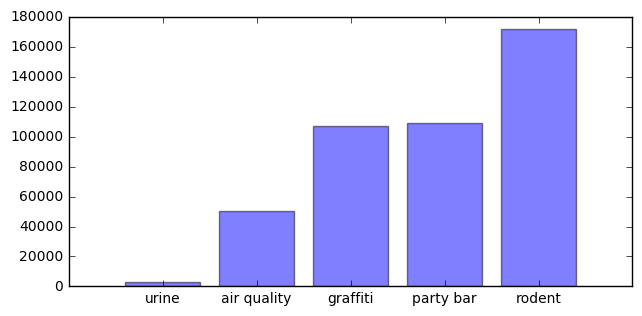

In [259]:
# Plot number of Complaints per type

# Dictionary with number of complaints per type
no_of_complaints = {"urine":len(urine),"rodent":len(rodent),"air quality":len(air),"graffiti":len(graffiti),
                    "party bar":len(party_bar)}   

# Sort dictionary by the ordered dictionary items
d = OrderedDict(sorted(no_of_complaints.items(), key=itemgetter(1))) 

# Plot
plt.subplot(421)
plt.bar(range(len(d)), d.values(), align="center", alpha=0.5)
plt.xticks(range(len(d)), d.keys())
plt.show()

**Insights:** The bar chart shows that rodents are the most common complaint type in our dataset (almost twice the size of the second largest issue, graffiti). We need to understand whether the issues have increased during the last 7 years as well as whether there are certain areas of the city where the issues are more common.

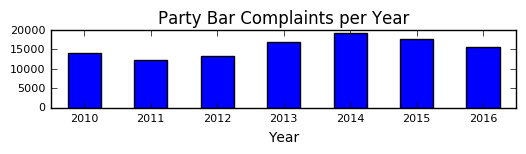

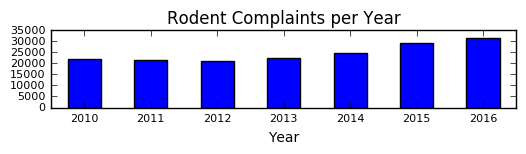

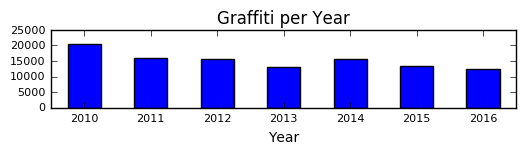

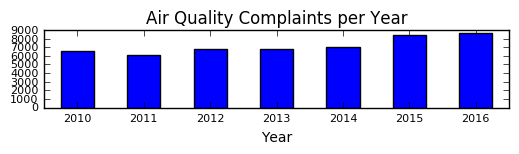

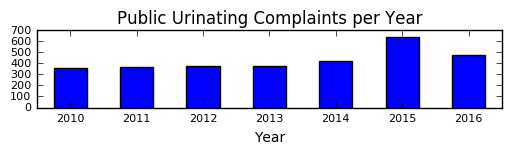

In [260]:
# Find yearly distribution of each complaint type
party_bar_year_dist = pd.pivot_table(party_bar, values='Unique Key', index=['Year'],aggfunc='count').reset_index()
rodent_year_dist = pd.pivot_table(rodent, values='Unique Key', index=['Year'],aggfunc='count').reset_index()
graffiti_year_dist = pd.pivot_table(graffiti, values='Unique Key', index=['Year'],aggfunc='count').reset_index()
air_year_dist = pd.pivot_table(air, values='Unique Key', index=['Year'],aggfunc='count').reset_index()
urine_year_dist = pd.pivot_table(urine, values='Unique Key', index=['Year'],aggfunc='count').reset_index()

# Plot Yearly distributions of Complaints
party_bar_year_dist.plot(x="Year",y="Unique Key", kind="bar",figsize=(6,1),title="Party Bar Complaints per Year",fontsize=8,rot=0,legend=None)
rodent_year_dist.plot(x="Year",y="Unique Key", kind="bar",figsize=(6,1),title="Rodent Complaints per Year",fontsize=8,rot=0,legend=None)
graffiti_year_dist.plot(x="Year",y="Unique Key", kind="bar",figsize=(6,1),title="Graffiti per Year",fontsize=8,rot=0,legend=None)
air_year_dist.plot(x="Year",y="Unique Key", kind="bar",figsize=(6,1),title="Air Quality Complaints per Year",fontsize=8,rot=0,legend=None)
urine_year_dist.plot(x="Year",y="Unique Key", kind="bar",figsize=(6,1),title="Public Urinating Complaints per Year",fontsize=8,rot=0,legend=None) 
plt.show()

The charts above provide us the following **insights**:
1. Party Complaints dropped in 2011 and started rising again in 2012-2013.
2. Rodent- and Air Quality Complaints were fairly stable until 2013, but have increased the last few years
3. Graffiti Complaints have decreased steadily throughout this decade.
4. Complaints about urinating in public have been stable - except for a peak in 2015. This is interesting, but not crucial information for this project, so we will not investigate this further.

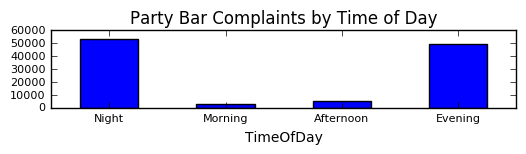

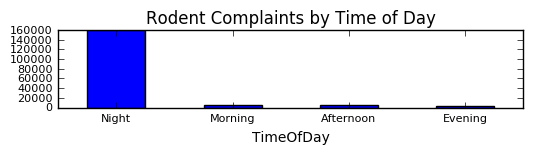

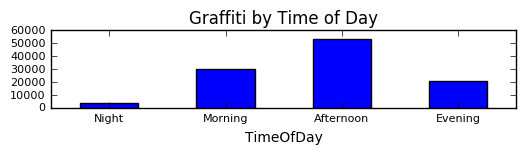

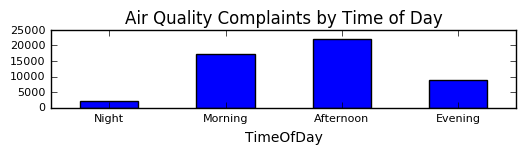

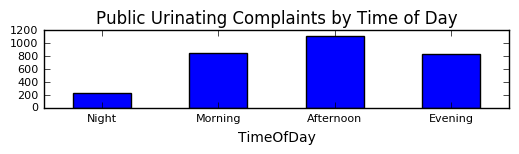

In [261]:
# Find Time of Day distribution of each complaint type
party_bar_TimeOfDay_dist = pd.pivot_table(party_bar, values='Unique Key', index=['TimeOfDay'],aggfunc='count').reset_index()
rodent_TimeOfDay_dist = pd.pivot_table(rodent, values='Unique Key', index=['TimeOfDay'],aggfunc='count').reset_index()
graffiti_TimeOfDay_dist = pd.pivot_table(graffiti, values='Unique Key', index=['TimeOfDay'],aggfunc='count').reset_index()
air_TimeOfDay_dist = pd.pivot_table(air, values='Unique Key', index=['TimeOfDay'],aggfunc='count').reset_index()
urine_TimeOfDay_dist = pd.pivot_table(urine, values='Unique Key', index=['TimeOfDay'],aggfunc='count').reset_index()

# Plot Time of day distributions of Complaints
party_bar_TimeOfDay_dist.plot(x="TimeOfDay",y="Unique Key", kind="bar",figsize=(6,1),title="Party Bar Complaints by Time of Day",fontsize=8,rot=0,legend=None)
rodent_TimeOfDay_dist.plot(x="TimeOfDay",y="Unique Key", kind="bar",figsize=(6,1),title="Rodent Complaints by Time of Day",fontsize=8,rot=0,legend=None)
graffiti_TimeOfDay_dist.plot(x="TimeOfDay",y="Unique Key", kind="bar",figsize=(6,1),title="Graffiti by Time of Day",fontsize=8,rot=0,legend=None)
air_TimeOfDay_dist.plot(x="TimeOfDay",y="Unique Key", kind="bar",figsize=(6,1),title="Air Quality Complaints by Time of Day",fontsize=8,rot=0,legend=None)
urine_TimeOfDay_dist.plot(x="TimeOfDay",y="Unique Key", kind="bar",figsize=(6,1),title="Public Urinating Complaints by Time of Day",fontsize=8,rot=0,legend=None)
plt.show()

The charts do not show any surprising **insights**. Basically, we see what we expected:
1. Party Bar Complaints occur during the evening and night.
2. Rodents are mainly spotted at night.
3. Graffiti, Air Quality and Public Urinating are mainly recorded at normal "awake" hours (morning, afternoon and evening).

Based on the above insights, we do not need to explore Time of Day further in our analysis.

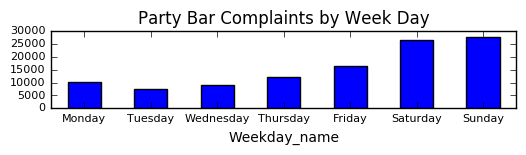

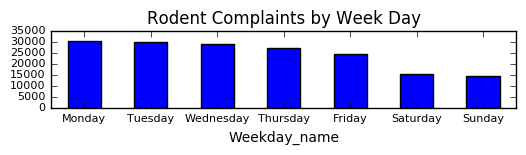

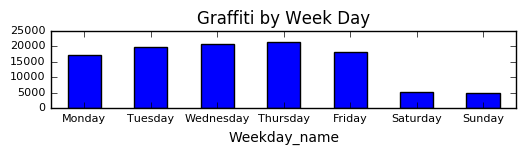

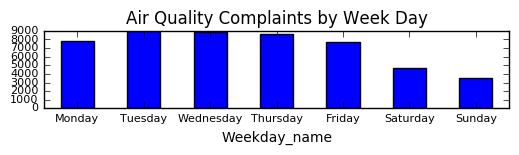

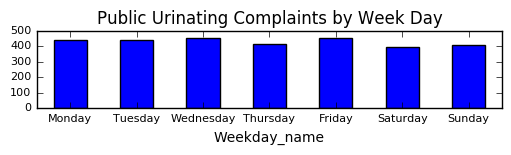

In [262]:
# Find weekday distribution of each complaint type
party_bar_Weekday_name_dist = pd.pivot_table(party_bar, values='Unique Key', index=['Weekday_name'],aggfunc='count').reset_index()
party_bar_Weekday_name_dist["Weekday_Order"] = [5,1,6,7,4,2,3]
party_bar_Weekday_name_dist = party_bar_Weekday_name_dist.sort_values(by="Weekday_Order",ascending=[True])

rodent_Weekday_name_dist = pd.pivot_table(rodent, values='Unique Key', index=['Weekday_name'],aggfunc='count').reset_index()
rodent_Weekday_name_dist["Weekday_Order"] = [5,1,6,7,4,2,3]
rodent_Weekday_name_dist = rodent_Weekday_name_dist.sort_values(by="Weekday_Order",ascending=[True])

graffiti_Weekday_name_dist = pd.pivot_table(graffiti, values='Unique Key', index=['Weekday_name'],aggfunc='count').reset_index()
graffiti_Weekday_name_dist["Weekday_Order"] = [5,1,6,7,4,2,3]
graffiti_Weekday_name_dist = graffiti_Weekday_name_dist.sort_values(by="Weekday_Order",ascending=[True])

air_Weekday_name_dist = pd.pivot_table(air, values='Unique Key', index=['Weekday_name'],aggfunc='count').reset_index()
air_Weekday_name_dist["Weekday_Order"] = [5,1,6,7,4,2,3]
air_Weekday_name_dist = air_Weekday_name_dist.sort_values(by="Weekday_Order",ascending=[True])

urine_Weekday_name_dist = pd.pivot_table(urine, values='Unique Key', index=['Weekday_name'],aggfunc='count').reset_index()
urine_Weekday_name_dist["Weekday_Order"] = [5,1,6,7,4,2,3]
urine_Weekday_name_dist = urine_Weekday_name_dist.sort_values(by="Weekday_Order",ascending=[True])

# Plot Weekday_name distributions of Complaints
ax1 = party_bar_Weekday_name_dist.plot(x="Weekday_name",y="Unique Key", kind="bar",title="Party Bar Complaints by Week Day",fontsize=8,rot=0,legend=None,figsize=(6,1))
ax2 = rodent_Weekday_name_dist.plot(x="Weekday_name",y="Unique Key", kind="bar",title="Rodent Complaints by Week Day",fontsize=8,rot=0,legend=None,figsize=(6,1))
ax3 = graffiti_Weekday_name_dist.plot(x="Weekday_name",y="Unique Key", kind="bar",title="Graffiti by Week Day",fontsize=8,rot=0,legend=None,figsize=(6,1))
ax4 = air_Weekday_name_dist.plot(x="Weekday_name",y="Unique Key", kind="bar",title="Air Quality Complaints by Week Day",fontsize=8,rot=0,legend=None,figsize=(6,1))
ax4 = urine_Weekday_name_dist.plot(x="Weekday_name",y="Unique Key", kind="bar",title="Public Urinating Complaints by Week Day",fontsize=8,rot=0,legend=None,figsize=(6,1))
plt.show()

The charts show a few interesting **insights**:
1. Not surprising, Party Bar Complaints occur during the weekend.
2. Three of the critical issues (Rodent-, Air Quality- and Public Urinating decrease during the weekend. This does not directly affect our search for the perfect location, but it does implicate that a bar running in the weekends will no be as affected as restaurant that would be open during the week.

Based on the above insights, we do not need to explore Weekday distribution further in our analysis.

('smallest non-zero count', 1.3097515906705499e-05)
('max count:', 24.530092268219004)
('smallest non-zero count', 1.0165006656003023e-06)
('max count:', 7.3967414118067012)
('smallest non-zero count', 3.6490060938010199e-08)
('max count:', 15.120646731565493)
('smallest non-zero count', 4.2292940046479448e-06)
('max count:', 3.9027105128317046)
('smallest non-zero count', 1.9261052803978676e-07)
('max count:', 0.49338207542983525)


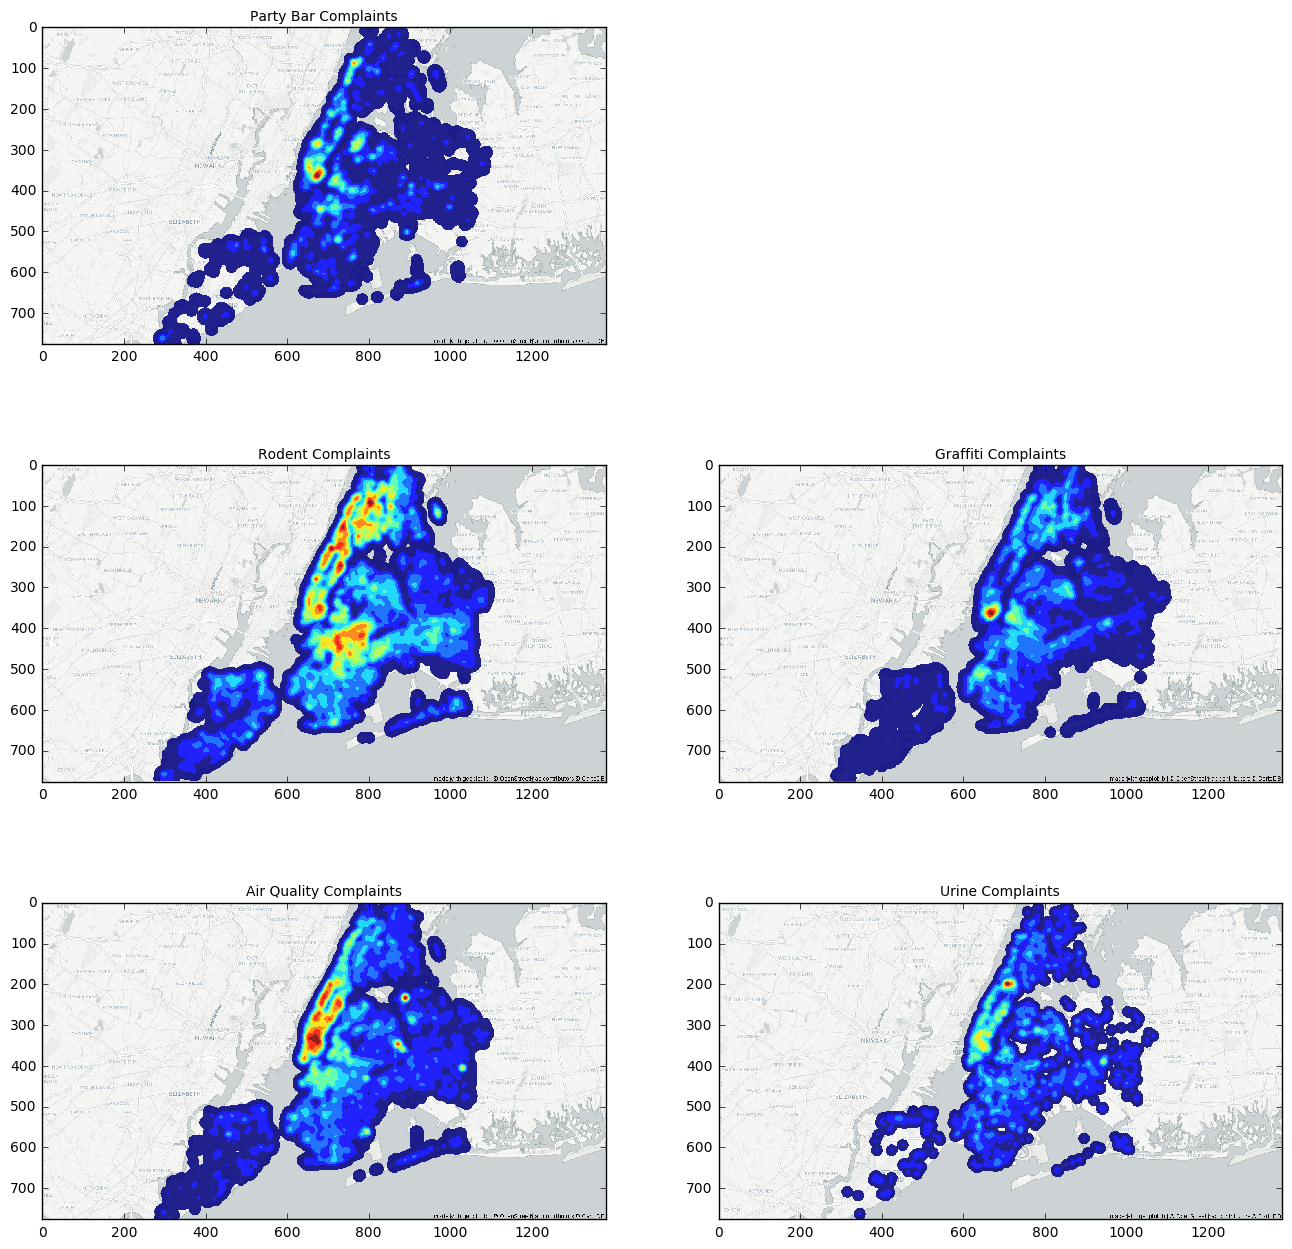

In [263]:
# Geographical plots of the Complaints Data

# Map of Party Bar Complaints
list_of_lat = party_bar["Latitude"] # List of latitudes
list_of_long = party_bar["Longitude"] # List of longitudes

# geoplotlib format
geo_data_for_plotting = {"lat": list_of_lat, 
                         "lon": list_of_long}
# To get a map only of NY
bbox = BoundingBox(north=max(list_of_lat), west=min(list_of_long), south=min(list_of_lat), east=max(list_of_long))
geoplotlib.set_bbox(bbox)
geoplotlib.kde(geo_data_for_plotting, bw=5, cmap='jet', cut_below=1e-4)
# geoplotlib.inline()
# Save fig in order to represent it later
geoplotlib.savefig('Party Bar')
img_party=mpimg.imread('Party Bar.png')


# Map of Rodent Complaints
list_of_lat = rodent["Latitude"] # List of latitudes
list_of_long = rodent["Longitude"] # List of longitudes

# geoplotlib format
geo_data_for_plotting = {"lat": list_of_lat, 
                         "lon": list_of_long}
# To get a map only of NY
bbox = BoundingBox(north=max(list_of_lat), west=min(list_of_long), south=min(list_of_lat), east=max(list_of_long))
geoplotlib.set_bbox(bbox)
geoplotlib.kde(geo_data_for_plotting, bw=5, cmap='jet', cut_below=1e-4)
# geoplotlib.inline()
# Save fig in order to represent it later
geoplotlib.savefig('Rodent')
img_rodent=mpimg.imread('Rodent.png')


# Map of Graffiti Complaints
list_of_lat = graffiti["Latitude"] # List of latitudes
list_of_long = graffiti["Longitude"] # List of longitudes

# geoplotlib format
geo_data_for_plotting = {"lat": list_of_lat, 
                         "lon": list_of_long}
# To get a map only of NY
bbox = BoundingBox(north=max(list_of_lat), west=min(list_of_long), south=min(list_of_lat), east=max(list_of_long))
geoplotlib.set_bbox(bbox)
geoplotlib.kde(geo_data_for_plotting, bw=5, cmap='jet', cut_below=1e-4)
# geoplotlib.inline()
# Save fig in order to represent it later
geoplotlib.savefig('Graffiti')
img_graffiti=mpimg.imread('Graffiti.png')


# Map of Air Qualiry Complaints
list_of_lat = air["Latitude"] # List of latitudes
list_of_long = air["Longitude"] # List of longitudes

# geoplotlib format
geo_data_for_plotting = {"lat": list_of_lat, 
                         "lon": list_of_long}
# To get a map only of NY
bbox = BoundingBox(north=max(list_of_lat), west=min(list_of_long), south=min(list_of_lat), east=max(list_of_long))
geoplotlib.set_bbox(bbox)
geoplotlib.kde(geo_data_for_plotting, bw=5, cmap='jet', cut_below=1e-4)
# geoplotlib.inline()
# Save fig in order to represent it later
geoplotlib.savefig('Air')
img_air=mpimg.imread('Air.png')


# Map of Urine Complaints
list_of_lat = urine["Latitude"] # List of latitudes
list_of_long = urine["Longitude"] # List of longitudes

# geoplotlib format
geo_data_for_plotting = {"lat": list_of_lat, 
                         "lon": list_of_long}
# To get a map only of NY
bbox = BoundingBox(north=max(list_of_lat), west=min(list_of_long), south=min(list_of_lat), east=max(list_of_long))
geoplotlib.set_bbox(bbox)
geoplotlib.kde(geo_data_for_plotting, bw=5, cmap='jet', cut_below=1e-4)
# geoplotlib.inline()
# Save fig in order to represent it later
geoplotlib.savefig('Urine')
img_urine=mpimg.imread('Urine.png')

# Plot maps
fig1 = plt.figure() # create a figure with the default size 

# im1 = img_party
ax1 = fig1.add_subplot(3,2,1) 
ax1.imshow(img_party, interpolation='none')
ax1.set_title('Party Bar Complaints', fontsize = 10)

ax1 = fig1.add_subplot(3,2,3) 
ax1.imshow(img_rodent, interpolation='none')
ax1.set_title('Rodent Complaints', fontsize = 10)

ax1 = fig1.add_subplot(3,2,5) 
ax1.imshow(img_air, interpolation='none')
ax1.set_title('Air Quality Complaints', fontsize = 10)

ax1 = fig1.add_subplot(3,2,4) 
ax1.imshow(img_graffiti, interpolation='none')
ax1.set_title('Graffiti Complaints', fontsize = 10)

ax1 = fig1.add_subplot(3,2,6) 
ax1.imshow(img_urine, interpolation='none')
ax1.set_title('Urine Complaints', fontsize = 10)

plt.show()

From the maps, we collect the following **insights**:
1. Manhattan is the place with most rodent and air quality complaints - which is probaly due to the high density population and car traffic in the area.
2. Rodents are a problem throughout Manhattan and Brooklyn.
3. There are places on Staten Island with no Party Bar Complaints (so we already know that that's not going to be the location for our bar), otherwise Party Bars seem to be spread around the city with (with an exception of East Village in Manhattan, where there seems to be a single spot with a large amount of parties).

### 2.3.2 Understanding Aggregated Datasets
Based on our datasets, we have created two aggregated datasets:<br />

**1a. Aggregated attributes per zip code.** We will use this dataset to conduct our machine learning analyses and explore the characteristics of the zip codes. We will narrow the city down to a short list of zip codes, where we believe to find the "sweet spot" for our bar.<br />

**1b. Aggregated attributes per zip code per year.** The yearly dataset will be used to investigate the chosen zip codes in the short list and look for patterns in the development of the area (e.g. are some areas more "up-and-coming" while others are on the way to becoming "so-last-season".)<br />

Before moving on, we want to understand the aggregated dataset (1a) better:

In [265]:
# Basic Stats of attributes

col_names = ['Urine Complaints', 'Rodent Complaints','Graffiti Complaints','Air Quality Complaints','Party Bar Complaints','Price per sqft', 'Total Trees','Share of Good']
means = []
st_dev = []
min_ = []
max_ = []
no_obs = []

for i in col_names:
    no_obs.append("%.0f" % total_data[i].count())
    means.append("%.2f" % total_data[i].mean())
    st_dev.append("%.2f" % total_data[i].std())
    min_.append("%.2f" % total_data[i].min())
    max_.append("%.2f" % total_data[i].max())

idx = ["No. of valid obs.","Mean","St.Dev","Min.","Max"]
basic_stats = pd.DataFrame.from_records([no_obs,means,st_dev,min_,max_], columns=col_names,index=idx)

# Print Basic Stats table 
basic_stats.transpose()


,No. of valid obs.,Mean,St.Dev,Min.,Max
Urine Complaints,205,14.66,14.94,0.00,97.00
Rodent Complaints,205,837.75,796.21,0.00,4577.00
Graffiti Complaints,205,522.45,620.23,0.00,4225.00
Air Quality Complaints,205,245.51,267.33,0.00,1485.00
Party Bar Complaints,205,533.62,782.72,0.00,4688.00
Price per sqft,129,514.20,326.27,153.75,1477.00
Total Trees,180,3620.23,2782.04,71.00,21356.00
Share of Good,180,0.80,0.08,0.45,0.95


The **basic stats** of our dataset show the following **insigts**:
1. The original Complaints Dataset consists of records for 205 different zip codes, while the Property Value Dataset and Tree Dataset consist of 129 and 180 zipcodes. In this project we are looking for a location that meets requirements within all attributes, so we will need to trim the dataset so it has valid values for all attributes. Our final dataset will consist of **129 observations**.
3. Most importantly, the table shows that the values of the attributes span across very different scales (maximum values span from 0.95 to 4,688), so before comparing the attributes in a statistical analysis, they will **need to be rescaled**.

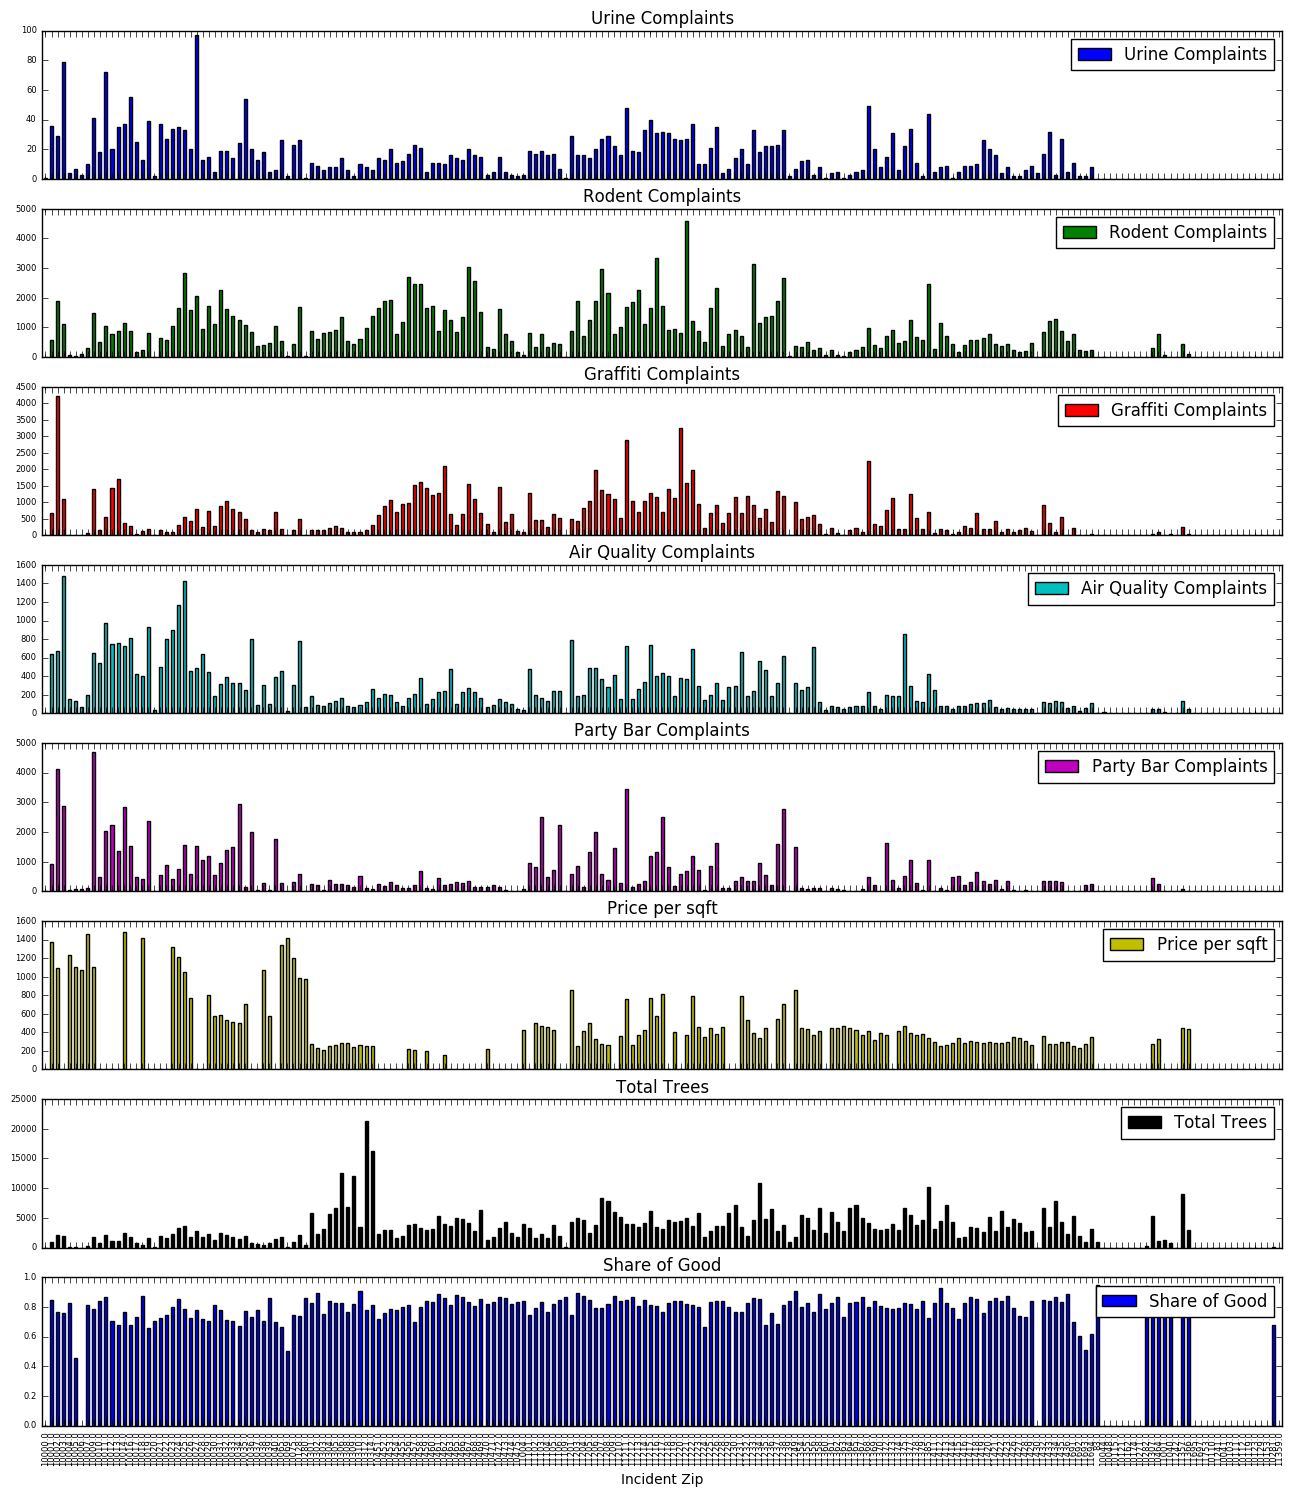

In [266]:
# As the aggregated dataset consists of only 205 observations, we can actually chart the value of 
# each attribute to investigate initial patterns in the data

total_data.plot(x="Incident Zip",y=list(total_data)[1:], kind="bar",figsize=(16,18),subplots=True,title=None,fontsize=6)
plt.show()

The charts above provide some important **insights**:
1. The same zip codes show high number of  rodent-, graffiti-, air quality- and urine complaints. We need to check for **correlation**.
2. Out of the 129 zip codes in the dataset, app. a dozen stand out as being heavy on the party scene (~ many party bar complaints). **Our location** is probably among one of these.
3. The zip codes from 10001 to 10280 have a **much higher property value** than the rest (these are mostly Manhattan zip codes)
4. A few zip codes have a **large number of trees** (~ 10,000-20,000 trees), while the rest of the areas are more equal.

## **2.4 Preprocessing - Part 2**

### 2.4.1 Rescaling Datasets
** In order to conduct the machine learning analyses, the attributes in the datasets need to be rescaled. **<br />
The attributes have very different scales, and in order to compare them, they need to be rescaled. In this project, we are interested in the relative values of the attributes compared to the maximum and minium (i.e. we are not interested in the actual no. of complaints, but rather if the complaints are high or low compared to the other areas). The appropriate rescaling in this project is a "max-min" rescaling, so the maximum value within each attribute is set to 1 and the miniumum is set to 0. By rescaling, the values will maintain their original distribution, but they will all be in the interval of [0,1].

In [267]:
# The attributes in the dataset have very different scales, so we will recale the data with MinMaxScaler, 
# so all attributes will span from 0 to 1 and become comparable

# Remove rows with NaN (attribute cannot be rescaled, if it contains NaNs)
total_data_clean = total_data.dropna()
total_data_yearly_clean = total_data_yearly.dropna()

# Remove Zip and Zip+Year column (these are categorical attributes, we don't want to rescale these)
total_data_trim = total_data_clean.drop("Incident Zip",1)
total_data_yearly_trim = total_data_yearly_clean.drop("Zip+Year",1)


In [268]:
# Rescale trimmed dataframes
col_names = list(total_data_trim)

min_max_scaler = preprocessing.MinMaxScaler()

np_rescaled = min_max_scaler.fit_transform(total_data_trim)
total_data_rescaled = pd.DataFrame(np_rescaled)

np_year_rescaled = min_max_scaler.fit_transform(total_data_yearly_trim)
total_data_yearly_rescaled = pd.DataFrame(np_year_rescaled)


In [269]:
# Put column names back on dataframes
total_data_rescaled.columns = col_names
total_data_yearly_rescaled.columns = col_names

# Put Incident Zip and Zip+Year back on the rescaled dataframes:
# First, the zip series needs to be converted to an array, otherwise the index will follow the pandas series 
# and the merge will fail

zip_np = total_data_clean['Incident Zip'].values
zip_year_np = total_data_yearly_clean['Zip+Year'].values

total_data_rescaled['Incident Zip'] = pd.DataFrame(zip_np)
total_data_yearly_rescaled['Zip+Year'] = pd.DataFrame(zip_year_np)

# 3. Theory and Analysis 
We want to identify the zip code with the perfect location for our bar. In our opinion, the perfect location meets the following requirements:
1. Well kept (characterized by having **many trees in a healthy condition**)
2. Wealthy (characterized by **expensive properties**)
3. "Happening" party scene (characterized by many complaints of **loud music from bars and restaurants**)
4. Pleasant (characterized by **few rodent-, graffiti-, air quality- and public urinating complaints**)

All this data is available to us, but we cannot grasp all the attributes without performing some unsupervised machine learning / data mining to find patterns in the data leading to the zip codes that meet our requirements.

The tools that we have chosen to apply on the dataset are **correlation analysis** and **K-means clustering**.
* The **correlation analysis** will tell us if we in fact need to include all attributes in the clustering (if some of the attributes are highly correlated, the clustering can be simplified by removing one the correlated attributes).
* **K-means clustering** aims to split the data into k clusters, in such a way that each observation belongs to the cluster with the nearest mean. The cluster mean will be a "prototype" of the cluster members. In our case, we hope to find a cluster where the prototype meets our requirements for the perfect location.


## 3.1 Correlation analysis
In the data exploration chapter, we saw indications of correlations in the attributes. We want to explore this further, and If some of the attributes are heaviyly correlated, we might want to remove them the cluster analysis.

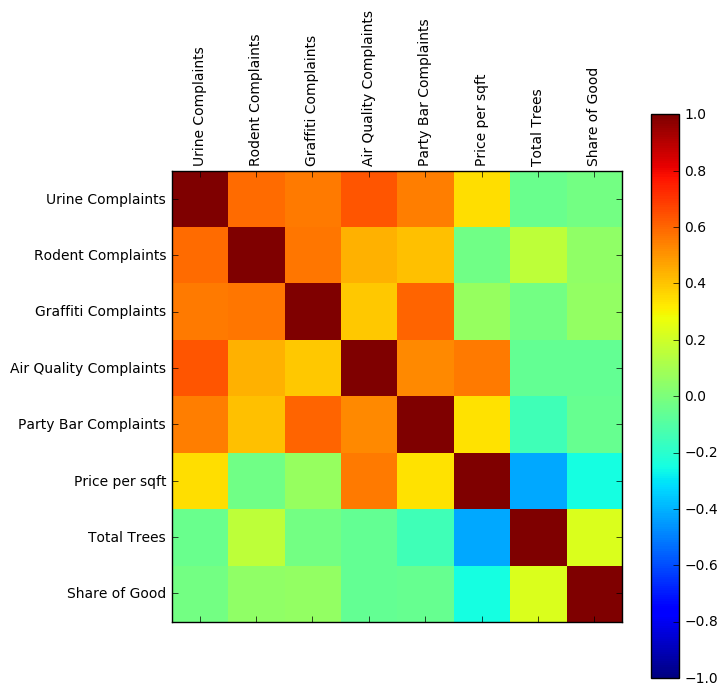

In [270]:
# Correction Matrix Plot

# Remove zip from the dataset, as it is a categorical attribute that should not be included in the correlation calculation)
raw_data = total_data_rescaled.drop("Incident Zip",1)

col_names = list(raw_data)
correlations = raw_data.corr()

# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(221)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,8,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(col_names,rotation=90)
ax.set_yticklabels(col_names)
plt.show()

The correlation plot shows some very interesting **insights**:
1. High correlations between the complaints leading to a pleasant/not pleasant neighbourhood (urine, rodents, graffiti and air quality
2. Unfortunately there is also a high correlation between the party scene and the unpleasantness of the area. This indicates that it might be difficult to find an area that is pleasant and "happening".
3. There is  negative correlation between number of trees (as well healthy trees) and property values, which is somewhat surprising (we expected wealthy neighbourhoods to have invested in the green environment)
4. There is a positive correlation between property value and air quality complaints (probably because of the Manhattan zip codes)

**Concequences**: The correlation analysis leads us to the decision of removing air quality complaints from the cluster analysis, as this attribute will blur our decision (we are looking for a wealthy neighbourhood with good air quality - this might prove impossible in New York City!). This decision is also backed up by evidence that the other complaint types will be enough to label a zip codes as "pleasant" or "not pleasant".

In [271]:
# Remove Air Quality Complaints from data to be clustered
raw_data = raw_data.drop("Air Quality Complaints",1)

## 3.2 Cluster analysis
The following section contains the full cluster analysis of the data. It is split into two sub sections:
1. Identification of clusters
2. Interpretation of clusters

### 3.2.1 Identification of clusters 

The number of clusters (k) is initially set to 20. In this project, we will not perform cross validation to identify the optimal number of clusters, because we are not looking for an objective optimal split of the data into k homogenic clusters: In our case, we are merely using this data mining technique as an explorative tool to group the observations and we will subjectively interpret the clusters. 

If k=20 does not lead to a cluster that meets our requirements, we will adjust k until we find a cluster with the required characteristics.

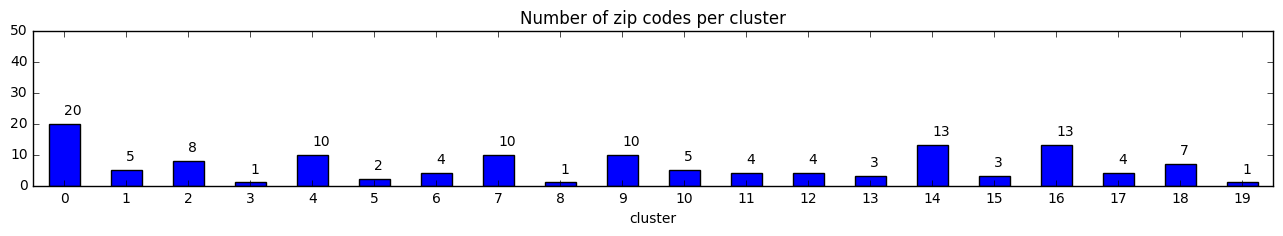

In [272]:
# Convert dataframe to matrix
mat = raw_data.as_matrix()
data = raw_data

# Set number of clusters
no_clusters = 20

# Run the model
km = KMeans(n_clusters=no_clusters, random_state=1)
km.fit(mat)
predict=km.predict(mat)

# Add cluster predictions to raw data
raw_data['cluster'] = pd.Series(predict, index=raw_data.index)

# Create counts and means of clusters
cluster_counts = pd.pivot_table(raw_data,columns=['cluster'],aggfunc='count')
cluster_means = pd.pivot_table(raw_data,columns=['cluster'])

# Create a column with cluster averages
cluster_means["Total"] = cluster_means.mean(axis=1)

# Rename index, remove redundant rows, add total column
cluster_counts = cluster_counts.rename({"Graffiti Complaints": "Counts"})
cluster_counts = cluster_counts.drop(cluster_counts.index[[1,2,3,4,5,6]])
cluster_counts["Total"] = cluster_counts.sum(axis=1)
cluster_counts = cluster_counts.astype(int)

# Print chart with number of zips per cluster
d = cluster_counts.transpose().reset_index()
d = d.drop(d.index[20],axis=0)

ax = d.plot(x="cluster",y="Counts", kind="bar",figsize=(16,2),title="Number of zip codes per cluster",fontsize=10, rot=0,legend=False)
ax.set_ylim(0, 50)

for i, label in enumerate(list(d.index)):
    counts = d.ix[label]['Counts']
    ax.annotate(str(counts), (i, counts+3))

The cluster analysis results in six large clusters (with 10 or more zip codes in the cluster) and 14 smaller clusters. In the following section, we will examine the characteristics of the 20 clusters.

### 3.2.2 Interpretation of clusters 

To intepret the clusters, we create a table showing the affinity of each attribute in the cluster compared to the average across the clusters. The affinity indicates whether the attribute is over-represented in the cluster. Affinity = 100 indicates an average level of the attribute, while affinity > 100 indicates an over-representation of the attrubute in the cluster.

We are looking for a cluster that meets our requirements, so we are looking for **high affinity of the good attributes** (Party Bar Complaints, Price per sqft, Total Trees and Share of Good), and **low affinity of the bad attributes** (Rodent-, Graffiti- and Urine Complaints)

In [273]:
# Create affinity table

cluster_aff = cluster_means.iloc[:].div(cluster_means["Total"],axis=0)
cluster_aff = cluster_aff*100
cluster_aff = cluster_aff.astype(int)
cluster_aff = cluster_aff.drop("Total", 1)
cluster_aff = cluster_aff.append(cluster_counts)
cluster_aff.style.apply(lambda x: ["background: green" if v > 105 else "" for v in x], axis = 1)

**Interpretation:** As expected, the affinity table shows that splitting the zip codes into 20 different clusters does not generate a clear cut cluster that meets all our requirements. Therefore, in order to choose the clusters for the location of our bar, we need to prioritize our requirements.

Our order of prioritization is:
1. "Happening" party scene (characterized by many complaints of loud music from bars and restaurants)
2. Wealthy (characterized by expensive properties)
3. Well kept (characterized by having many trees in healthy condition)
4. Pleasant (characterized by few rodent-, graffiti-, air quality- and public urinating complaints)


**Conclusion:** Based on our prioritization, we find that **cluster #17** is the best choice for our bar location. It is a wealthy cluster (aff = 223), there is a good party scene (aff = 116) and the trees are good condition (aff = 111). Unfortunately there are many urine complaints (aff = 185), but it is a trade-off we are willing to make.

### 3.2.3 Further analysis of the chosen cluster

We want to make a simple visualization of the zip codes and the chosen cluster. Based on our prioritizaion of the attributes, we calculate an "niceness score" for each zip code as a weighted average of the attributes. We work with the following weights:

In [274]:
weights=pd.DataFrame({'Attributes': ['Urine Complaints', 'Rodent Complaints', 'Graffiti Complaints',
 'Price per sqft', 'Total Trees', 'Share of Good'],
                 'Weight': [-1,-2,-1,3,2,3],})
weights

,Attributes,Weight
0,Urine Complaints,-1
1,Rodent Complaints,-2
2,Graffiti Complaints,-1
3,Price per sqft,3
4,Total Trees,2
5,Share of Good,3


In [275]:
# Niceness score is calculated by weighing each rescaled attribute with their importance for niceness
total_data_rescaled["Niceness"] = total_data_rescaled["Rodent Complaints"]*(-2) + total_data_rescaled["Price per sqft"]*3 + total_data_rescaled["Share of Good"]*3 + total_data_rescaled["Total Trees"]*2 + total_data_rescaled["Urine Complaints"]*(-1) + total_data_rescaled["Graffiti Complaints"]*(-1)    

# Niceness is MinMax rescaled
min_max_scaler = preprocessing.MinMaxScaler()
niceness_scaled = min_max_scaler.fit_transform(total_data_rescaled["Niceness"].reshape(-1,1)) #reshape needed due to error if not reshaped
total_data_rescaled["Niceness_rescaled"] = pd.DataFrame(niceness_scaled)


Before we investigate the zip codes in cluster #17, we make a scatter plot of Party Bar Complaints vs "Niceness" to get an overview of all zip codes and their position within the sphere of "Party Scene vs Niceness":

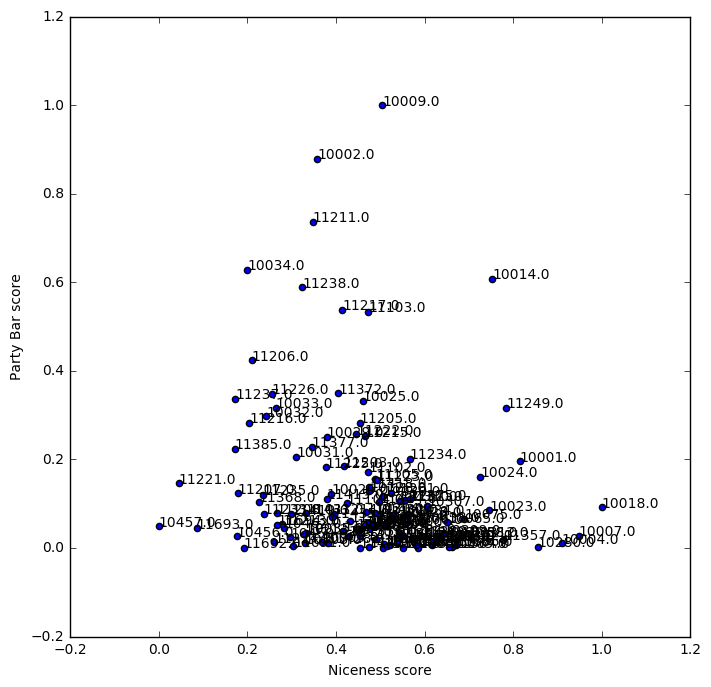

In [276]:
z=total_data_rescaled["Niceness_rescaled"]
y=total_data_rescaled["Party Bar Complaints"]
n=total_data_rescaled["Incident Zip"]

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(z, y)
plt.xlabel("Niceness score")
plt.ylabel("Party Bar score")

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))
    
plt.show()

We are looking for zip codes in the top right corner of the plot, and the plot confirms that there are in fact only a few zip codes that have a high Party Bar complaint score **and** a high Niceness score. The plot shows, that there are no zip codes in the top right corner, but the cluster analysis enables us to find the best solution in this not-optimal situation. The analysis showed that cluster #17 included the zip codes that best complied with our requirements.

Below we will **identify the zip codes** that belong to our cluster #17:

In [277]:
# Add predicted clusters to total_data_rescaled
total_data_rescaled["cluster"] = raw_data["cluster"]

# Identify the zips of chosen cluster 
chosen_cluster = [17]
chosen_df = total_data_rescaled.loc[total_data_rescaled['cluster'].isin(chosen_cluster)]
chosen_zips = chosen_df["Incident Zip"].tolist()
print "The short list of zip codes is", chosen_zips


The short list of zip codes is [10001.0, 10014.0, 10023.0, 10024.0]


# 4. Visualizations

Our website consists of three visualisations:
1. Zip Code Map of New York showing the **scores of each attribute** in our analysis. This map gives the reader an idea of how the attributes are spread across New York.
2.  Zip Code Map of New York **color coded by the 20 clusters**. This will indicate the number of zip codes in each cluster and the geographic position of the clusters
3. Interactive bubble chart of **"Party vs. Niceness"** showing the development of the two attributes for each of the four chosen zip codes. We want the location of our bar to be hip and up-and-coming, so we will look for zip with a positive path.

The bubble chart needs the nicessness score to be added to the yearly dataset. In order to do so, the niceness score needs to be added to the yearly dataset.

In [278]:
# Calculating Niceness score per zip per year

# Niceness score is calculated by weighing each rescaled attribute with their importance for niceness
total_data_yearly_rescaled["Niceness"] = total_data_yearly_rescaled["Rodent Complaints"]*(-2) + total_data_yearly_rescaled["Price per sqft"]*3 + total_data_yearly_rescaled["Share of Good"]*3 + total_data_yearly_rescaled["Total Trees"]*2 + total_data_yearly_rescaled["Urine Complaints"]*(-1) + total_data_yearly_rescaled["Graffiti Complaints"]*(-1)    

# Niceness is MinMax rescaled
min_max_scaler = preprocessing.MinMaxScaler()
niceness_yearly_scaled = min_max_scaler.fit_transform(total_data_yearly_rescaled["Niceness"].reshape(-1,1)) #reshape needed due to error if not reshaped
total_data_yearly_rescaled["Niceness_rescaled"] = pd.DataFrame(niceness_yearly_scaled)

# Visualisation requires that Zip+Year is "deconcatenated"
total_data_yearly_rescaled["Incident Zip"] = total_data_yearly_rescaled["Zip+Year"].str[0:7].astype(float)
total_data_yearly_rescaled["Year"] = total_data_yearly_rescaled["Zip+Year"].str[-4:] 

Before creating the interactive bubble chart on the website, we can create two simple line charts showing the development of Party Bar and Niceness. These two charts will give us the same information as the bubble chart - but will not be nice enough to post on the website:

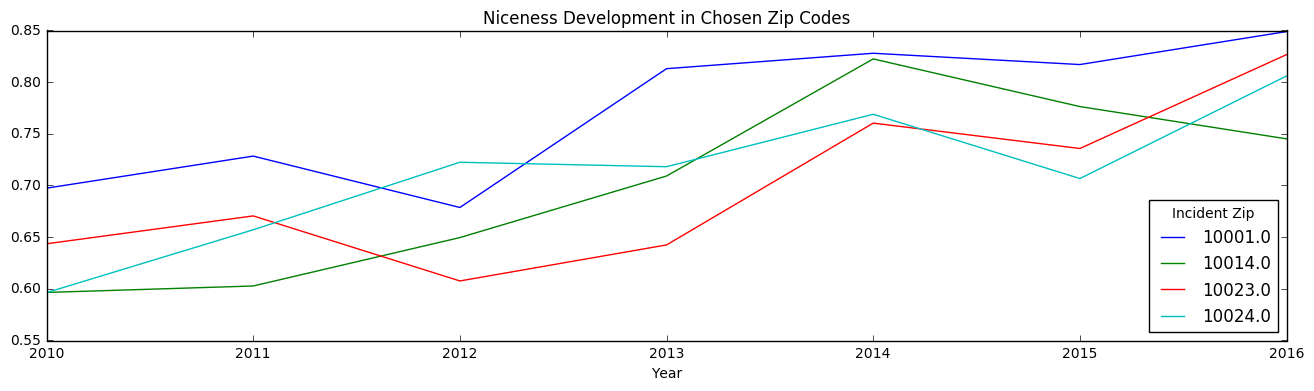

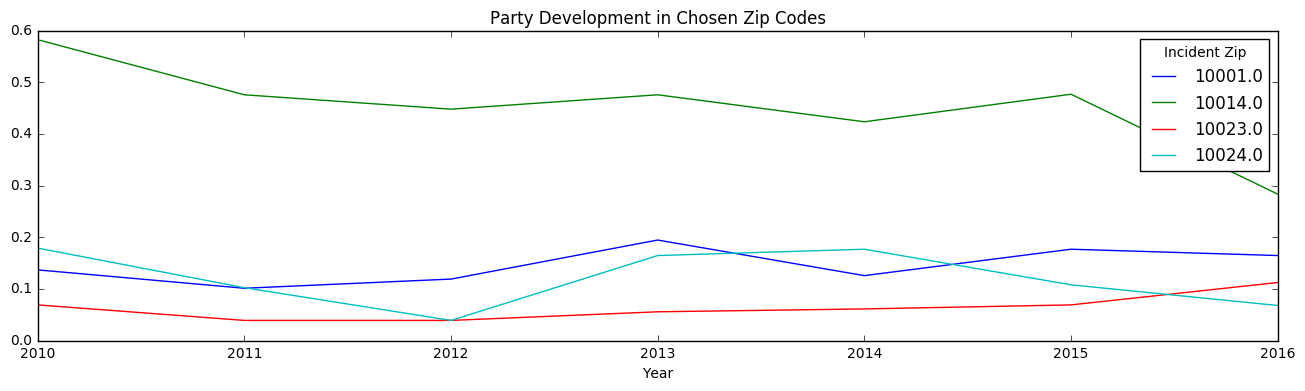

In [279]:
# Plots of Nicesness and Party Development
niceness_yearly = pd.pivot_table(total_data_yearly_rescaled, values='Niceness_rescaled', columns=["Incident Zip"],index=["Year"],aggfunc='mean')
niceness_yearly = niceness_yearly.reset_index()

party_yearly = pd.pivot_table(total_data_yearly_rescaled, values='Party Bar Complaints', columns=["Incident Zip"],index=["Year"],aggfunc='mean')
party_yearly = party_yearly.reset_index()

niceness_yearly.plot(x="Year", y=chosen_zips,figsize=(16,4),title="Niceness Development in Chosen Zip Codes",fontsize=10)

party_yearly.plot(x="Year", y=chosen_zips,figsize=(16,4),title="Party Development in Chosen Zip Codes",fontsize=10)
plt.show()

Based on the charts of Party Bar and Niceness, we see that **zip code 10014** is the preferable zip among the four. The reasons being;
1. Although the party development has declined the last 7 years, it is still well above the other zip codes in the short list. 
2. The Niceness of the neighbourhood is not among the top, but it has increased well since 2010.

In [280]:
# We will create more fancy vizualisations in D3, so the data for these visualizations are reformated exported:

chosen_yearly_d3_formatted = total_data_yearly_rescaled.loc[total_data_yearly_rescaled['Incident Zip'].isin(chosen_zips)]
chosen_yearly_d3_formatted = chosen_yearly_d3_formatted.filter(items=["Party Bar Complaints","Niceness_rescaled","Incident Zip","Year"])
chosen_yearly_d3_formatted = chosen_yearly_d3_formatted.rename(columns={"Party Bar Complaints": "Party_Bar_Complaints","Incident Zip":"Incident_Zip"})
chosen_yearly_d3_formatted = chosen_yearly_d3_formatted.sort_values(by=['Incident_Zip',"Year"], ascending=[1,1])
chosen_yearly_d3_formatted.to_csv("C:/Users/Luisa HP/Google Drive/DTU/02806 Social Data Analysis/Final Project/chosen_yearly_d3_formatted.csv")

total_data_rescaled_d3_formatted = total_data_rescaled
total_data_rescaled_d3_formatted = total_data_rescaled_d3_formatted.drop("Niceness",1)
total_data_rescaled_d3_formatted = total_data_rescaled_d3_formatted.rename(columns={"Urine Complaints": "Urine_Complaints", "Rodent Complaints" :"Rodent_Complaints",
                                                                  "Graffiti Complaints":"Graffiti_Complaints", "Air Quality Complaints":"Air_Quality_Complaints" ,
                                                                  "Party Bar Complaints": "Party_Bar_Complaints", "Price per sqft":"Price_per_sqft", 
                                                                  "Total Trees":"Total_Trees", "Share of Good":"Share_of_Good", "Incident Zip":"Incident_Zip"})
total_data_rescaled_d3_formatted.to_csv("C:/Users/Luisa HP/Google Drive/DTU/02806 Social Data Analysis/Final Project/total_data_rescaled_d3_formatted.csv")

total_data_d3_formatted = total_data
total_data_d3_formatted.fillna(0)
total_data_d3_formatted = total_data_d3_formatted.rename(columns={"Urine Complaints": "Urine_Complaints", "Rodent Complaints" :"Rodent_Complaints",
                                                                  "Graffiti Complaints":"Graffiti_Complaints", "Air Quality Complaints":"Air_Quality_Complaints" ,
                                                                  "Party Bar Complaints": "Party_Bar_Complaints", "Price per sqft":"Price_per_sqft", 
                                                                  "Total Trees":"Total_Trees", "Share of Good":"Share_of_Good", "Incident Zip":"Incident_Zip"})
total_data_d3_formatted.to_csv("C:/Users/Luisa HP/Google Drive/DTU/02806 Social Data Analysis/Final Project/total_data_d3_formatted.csv")


# 5. Discussion. Think critically about your creation
We have managed to use a combination of three very different datasets in the analysis, and we have managed to find the best location for our bar - so all in all, the project has been succesful.

However, as it turned out, none of the zip codes showed to be a perfect match for our requirements, so given more time, we could have added more attributes to the model and explored other qualitative information about the city. 

Furthermore this analysis could have been improved by addtional data:
1. About actual bars in New York and their popularity. This data is possibly available through site such as Google Maps and Tripadvisor and could have been used in predictive analysis to help us understand what in fact drives the popularity of a bar.
2. About the population density in the areas. We have assumed that complaints are a good descriptor of the area, but in fact the population density is a critical factor that could change the results of the analysis (we searched extensively for popoulation statistics per zip code, but did not succeed in finding any usable datasets).


Lastly, in reality the choice to open a bar in New York would require much more research such as:
* The "Niceness factor" is very decive in our model. Have we chosen the correct attributes to describe the attractiveness or an area? Have we used the correct weights?
* Are there areas of New York that are not well represented in the dataset? A more extensive analysis should be conducted
* How is the real feel and atmosphere of the areas? A personal visit would be required.